# 9주차 실습

- 1. Topic Trend - Movie
- 2. Word2Vec
- 3. Keras RNN based Classification
---

 # 1. Topic trend - Movie
 
 ### data load

In [1]:
import matplotlib
%matplotlib inline
import pandas as pd

In [2]:
data = pd.read_csv("movie_data_include_date.csv", header=None, names=['review', 'rate', 'date', 'title']) #read data

In [3]:
for ix, name in enumerate(data.columns):
    print(ix,name)

0 review
1 rate
2 date
3 title


In [4]:
data.head()

,review,rate,date,title
0,돈 들인건 티가 나지만 보는 내내 하품만,1,2018.10.29,인피니티 워
1,몰입할수밖에 없다. 어렵게 생각할 필요없다. 내가 전투에 참여한듯 손에 땀이남.,10,2018.10.26,인피니티 워
2,이전 작품에 비해 더 화려하고 스케일도 커졌지만.... 전국 맛집의 음식들을 한데 ...,8,2018.10.24,인피니티 워
3,이 정도면 볼만하다고 할 수 있음!,8,2018.10.22,인피니티 워
4,재미있다,10,2018.10.20,인피니티 워


In [5]:
data.review.shape
type(data.review)

pandas.core.series.Series

## Count vector with Scikit

In [6]:
from konlpy.tag import Okt #konlpy에서 Twitter 형태소 분석기를 import
twitter_tag = Okt()

def tokenizer(str):
    return [token for token in twitter_tag.nouns(str) if len(token) > 1]

In [7]:
from sklearn.feature_extraction.text import CountVectorizer

vec = CountVectorizer(tokenizer=tokenizer, #우선은 명사만 사용
                      decode_error ='ignore', 
                      max_df=0.5, #너무 자주 나타나는 단어는 제외, 책에서는 0.15를 사용
                      #min_df = 3, #3개 미만의 문서에서 나타난 단어는 제외, 여기서는 max_features를 1000으로 제한하므로 별 필요 없음
                      max_features = 1000) #적당한 대상 단어 수를 선택
review_cv = vec.fit_transform(data.review)

In [8]:
review_cv.shape

(14725, 1000)

## Applying LDA into countVector

In [9]:
from sklearn.decomposition import LatentDirichletAllocation

lda = LatentDirichletAllocation(n_components = 10, #추출할 topic의 수를 지정
                                max_iter=25, #max_iter는 최종 모형에서는 5,000~10,000번 시도한다고 알려져 있음
                                topic_word_prior= 0.1, doc_topic_prior=1.0,
                                #topic_word_prior: beta, doc_topic_prior: alpha
                                #일반적으로 beta는 0.1로 고정하고 alpha를 50/topic의 수 근처의 값을 시도
                                #alpha와 beta는 낮은 값을 사용할수록 특정 토픽들이 두드러지도록 하는 효과가 있다고 합
                                learning_method='batch', #'batch'는 'online'에 비해 더 성능이 좋고 느림, 현재는 default
                                n_jobs= -1, #사용 processor 수, None이면 1, -1이면 모두 사용
                                random_state=0)

review_topics = lda.fit_transform(review_cv)

In [10]:
print(review_topics.shape)
type(review_topics)

(14725, 10)


numpy.ndarray

## LDA topic modeling

In [11]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d: " % topic_idx, end='')
        print(", ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))
        #print(", ".join([feature_names[i]+'('+str(topic[i])+')' for i in topic.argsort()[:-n_top_words - 1:-1]]))
        # 위 slicing에서 맨 뒤 -1은 역순을 의미, 역순으로 했을 때 처음부터 n_top_words까지
    print()

- 토픽 모델링을 통해 비슷한 토픽으로 묶인 단어들의 출력

In [12]:
print_top_words(lda,vec.get_feature_names(), 10)

Topic #0: 감동, 스토리, 기대, 내용, 원작, 신파, 웹툰, 별로, 억지, 나름
Topic #1: 마블, 영화, 노스, 다음, 이해, 결말, 사람, 어벤져스, 다른, 이영화
Topic #2: 마지막, 장면, 영화, 감독, 부분, 송강호, 하나, 모두, 작품, 때문
Topic #3: 진짜, 사람, 광주, 역사, 가슴, 우리, 영화, 지금, 사실, 정도
Topic #4: 영화, 보고, 그냥, 느낌, 처음, 차태현, 몰입, 관객, 천만, 정도
Topic #5: 영화, 정말, 최고, 시간, 사랑, 이야기, 현실, 연기력, 내내, 노래
Topic #6: 영화, 재미, 중간, 액션, 인생, 음악, 조금, 한국영, 이상, 이건
Topic #7: 생각, 눈물, 영화, 평점, 가족, 마음, 기억, 공포, 개인, 소재
Topic #8: 연기, 배우, 마동석, 윤계상, 한번, 영화, 대박, 조연, 간만, 제대로
Topic #9: 영화, 공포영화, 완전, 추천, 수준, 보기, 아이, 소리, 아주, 초반



In [13]:
trend_data = pd.DataFrame(review_topics, columns=['topic'+str(i) for i in range(1, 11)])

In [14]:
trend_data.head()

,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,topic10
0,0.083333,0.083333,0.083333,0.085227,0.083333,0.164773,0.083333,0.083333,0.166666,0.083333
1,0.083719,0.083474,0.083334,0.083412,0.166804,0.083599,0.083333,0.165561,0.083339,0.083424
2,0.061579,0.173715,0.235294,0.058824,0.117647,0.058824,0.117646,0.058824,0.058824,0.058824
3,0.099623,0.092738,0.092533,0.128630,0.120396,0.090909,0.093225,0.093004,0.095131,0.093810
4,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000


In [15]:
trend_data = pd.concat([trend_data, data.date], axis=1)

In [16]:
trend_data.shape

(14725, 11)

In [17]:
trend_data.head()

,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,topic10,date
0,0.083333,0.083333,0.083333,0.085227,0.083333,0.164773,0.083333,0.083333,0.166666,0.083333,2018.10.29
1,0.083719,0.083474,0.083334,0.083412,0.166804,0.083599,0.083333,0.165561,0.083339,0.083424,2018.10.26
2,0.061579,0.173715,0.235294,0.058824,0.117647,0.058824,0.117646,0.058824,0.058824,0.058824,2018.10.24
3,0.099623,0.092738,0.092533,0.128630,0.120396,0.090909,0.093225,0.093004,0.095131,0.093810,2018.10.22
4,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,2018.10.20


In [18]:
trend = trend_data.groupby(['date']).mean()

In [19]:
trend.shape

(640, 10)

In [20]:
trend.head()

,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,topic10
date,,,,,,,,,,
2016.04.27,0.058931,0.121572,0.183691,0.119880,0.133482,0.132234,0.069273,0.060602,0.059965,0.060368
2016.05.09,0.222643,0.094897,0.062148,0.073525,0.099706,0.090204,0.073010,0.109825,0.112139,0.061904
2016.05.20,0.312642,0.062559,0.062500,0.125000,0.071146,0.062500,0.062571,0.062500,0.116082,0.062500
2016.06.04,0.083333,0.084768,0.129015,0.083333,0.083333,0.083333,0.083333,0.083333,0.166667,0.119550
2016.07.09,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000


In [21]:
len(set(trend_data.date))

640

In [22]:
#jupyter에서 matplotlib을 사용해 만든 graph를 화면에 표시하기 위해 필요
%matplotlib inline 

import matplotlib.pyplot as plt

#아래는 한글을 사용할 때 깨지는 문제에 대한 해결
from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)

#그래프의 축 등에서 음수를 표시할 때 minus sign이 깨지는 것 해결
import matplotlib as mpl
mpl.rcParams['axes.unicode_minus'] = False

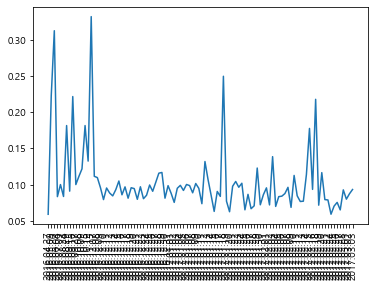

In [25]:
plt.plot(trend.index[:100], trend.topic1[:100])
plt.xticks(rotation=90)

plt.show()

---
# 2. W2V (Word2Vec)

In [26]:
import csv

contents = []
labels = []
with open('petition_sample.csv', encoding='utf-8') as csvfile:
    csvreader = csv.reader(csvfile)
    for row in csvreader:
        #print(row)
        if row: #그 줄에 내용이 있는 경우에만
            contents.append(row[0]) #청원내용을 contents 리스트에 추가
            labels.append(row[1]) #청원 category를 labels 리스트에 추가

In [27]:
print('documents size:', len(contents))
print('labels:', set(labels))
print('document sample:', contents[0])

documents size: 4000
labels: {'미래', '일자리', '육아/교육', '반려동물'}
document sample: 만일 하시는 대통령님 및 각 부처 장관님,주무관님들 안녕하세요!!\n전남 목포에서 자영업을 하는 사람입니다.\n국정운영을 너무 잘해주셔서  감사하다는 인사를 먼저드리겠습니다.\n제가 청원 드리고자 하는 사안은 아래와 같습니다.\n그 사안은 개성공단 관련 부분입니다.\n이 사안은 오래전 개성공단이 폐쇄 되고, 그와 관련되어 문제들이 돌출되면서 한번씩 생각해봤습니다.\n개성공단의 상징성은 제가 부연하지 않아도 아주 잘 아실거라 생각 하고 요점만 정리하여 말씀드리겠습니다.\n저는 개성공단을 북측에 꼭 설치 해야되나 하는 의문이 계속 들었습니다.\n북측과 인접한 강원도의 적합한 지역에 제2의 개성공단을  설치하면 안되나 하고 말이지요.\n공단이 설치가 된다면, 강원지역의 경제활성화와 중소기업에 돌아가는 혜택, 북측에 공단이 위치했을때\n지리적 불안전에서 오는 위험 해소, 제2의 개성공단이라는 남북화해의 상징성 등을 두루 갖추지 않을까 싶습니다.\n또한 요즘 처럼 대북관계의 긴장감에서 오는 불안함이 제2의 개성공단 설치로 인하여 대화의 창구를 열어\n관계를 계속 유지해간다면 긴장감이 어느 정도 해소 되지 않을까 싶습니다.\n이상으로 부족한 글 읽어주셔서 감사합니다.


In [28]:
from sklearn.model_selection import train_test_split

# split data and labels into a training and a test set
X_train, X_test, y_train, y_test = train_test_split(contents, labels, random_state=0)

In [29]:
from konlpy.tag import Okt #konlpy에서 Twitter 형태소 분석기를 import
#from konlpy.tag import Twitter #konlpy에서 Twitter 형태소 분석기를 import
twitter_tag = Okt()
#twitter_tag = Twitter()

In [30]:
def tokenize(doc):
    #return list(filter (lambda token: len(token) > 1, twitter_tag.morphs(doc)))
    return list(filter (lambda token: len(token) > 1, twitter_tag.nouns(doc)))

In [31]:
print(twitter_tag.nouns(X_train[1])[:100])

['문재인', '대통령', '국정', '책임', '수고', '항상', '마음속', '응원', '지지', '저', '대기업', '통신사', '협력', '업체', '외주', '노동자', '우리', '문재인', '정부', '서민', '위', '사람', '먼저', '국정', '철학', '부합', '진정', '현실', '좀더', '면', '보고', '우선', '제', '생업', '일자리', '수입', '구조', '말씀', '저', '통신', '공사', '관련', '일', '외주', '노동자', '생활', '년', '가장', '아이', '명', '이일', '아이', '물런', '한번', '안정', '고정', '수입', '우리나라', '통신사', '대기업', '구조', '이', '협력', '업체', '지역구', '어서', '모든', '설치', '시공', '설비', '관련', '장일', '그', '영세', '협력', '업체', '대부분', '외주', '일용직', '노동자', '능직', '이', '의', '관점', '그', '일', '생업', '것', '고정', '여제', '대부분', '건', '얼마', '정액', '제', '수입', '불', '안정', '있을떄', '못']


In [32]:
print(twitter_tag.morphs(X_train[1])[:100])

['문재인', '대통령', '님', ',', '국정', '을', '책임', '지느라', '수고', '가', '많습니다', '항상', '마음속', '으로', '응원', '하고', '지지', '합니다', '\\', 'n', '저', '는', '대기업', '통신사', '들', '의', '협력', '업체', '에서', '일을하는', '외주', '노동자', '입니다', '\\', 'n', '우리', '문재인', '정부', '가', '서민', '을', '위', '하고', '사람', '이', '먼저', '이다', '라는', '국정', '철학', '에', '부합', '하고자', '한다면', '진정', '현실', '을', '\\', 'n', '좀더', '면', '면', '희', '들여다', '보고', '아셔야', '합니다', '안타깝습니다', '\\', 'n', '우선', ',', '제', '가', '생업', '으로', '하고있는', '일자리', '수입', '원', '구조', '부터', '말씀', '드리겠습니다', '\\', 'n', '저', '는', '통신', '공사', '관련', '일', '을', '하고', '있는', '외주', '노동자', '생활', '을', '근']


In [33]:
print(tokenize(X_train[1])[:100])

['문재인', '대통령', '국정', '책임', '수고', '항상', '마음속', '응원', '지지', '대기업', '통신사', '협력', '업체', '외주', '노동자', '우리', '문재인', '정부', '서민', '사람', '먼저', '국정', '철학', '부합', '진정', '현실', '좀더', '보고', '우선', '생업', '일자리', '수입', '구조', '말씀', '통신', '공사', '관련', '외주', '노동자', '생활', '가장', '아이', '이일', '아이', '물런', '한번', '안정', '고정', '수입', '우리나라', '통신사', '대기업', '구조', '협력', '업체', '지역구', '어서', '모든', '설치', '시공', '설비', '관련', '장일', '영세', '협력', '업체', '대부분', '외주', '일용직', '노동자', '능직', '관점', '생업', '고정', '여제', '대부분', '얼마', '정액', '수입', '안정', '있을떄', '실정', '그것', '이일', '종사', '사람', '전국', '적지', '그간', '대기업', '협력', '업체', '갑질', '둘째', '간다', '해도', '임금', '지급', '대기업', '먼저']


In [34]:
train_texts = [tokenize(text) for text in X_train]
test_texts = [tokenize(text) for text in X_test]

In [35]:
print('train text counts:', len(train_texts), ', test text counts:', len(test_texts))
print("train text sample", X_train[1])
print("tokenized result", train_texts[1])
print("test text sample", X_test[0])
print("tokenized result", test_texts[1])

train text counts: 3000 , test text counts: 1000
train text sample 문재인 대통령님, 국정을 책임 지느라 수고가 많습니다 항상 마음속으로 응원하고 지지합니다\n저는 대기업 통신사들의 협력업체 에서 일을하는 외주 노동자 입니다\n우리 문재인 정부가 서민을 위하고 사람이 먼저이다 라는 국정철학에  부합 하고자 한다면 진정 현실을\n좀더 면면희 들여다 보고 아셔야 합니다  안타깝습니다\n우선, 제가 생업으로 하고있는 일자리 수입원 구조부터 말씀 드리겠습니다\n저는 통신공사 관련일을 하고 있는 외주 노동자 생활을 근 20여년 해오고 있는 가장 입니다\n아이가 3명이고 이일을 해서 아이들을 키우고 있습니다\n물런 단한번도 안정적 이고 고정적인 수입이 없었습니다  그러면 우리나라 통신사 대기업들의 구조를\n보면 이들은 협력업체를 지역구에 두어서 모든 설치 시공 설비 관련 현장일을 시키고 있습니다\n그 영세한 협력업체들은 대부분 외주 일용직 노동자 들을 (기능직 이죠) 저의관점 에서는\n그 일을 생업으로 하는 것이 고정급여제가 아니고 대부분 한건당 얼마의 정액제 입니다\n그러다 보니 수입은 불안정 하고 일이 있을떄는 하고 없으면 못하고 그런실정 입니다\n그것까지 탓을 할수는 없다는것은 알고 있습니다\n이일에 종사하는 사람들이 전국에 적지 않습니다,\n그간 대기업들의 협력업체들 에게 갑질이니, 머니 그런것은 둘째로 치고 넘어 간다고 해도\n임금 지급은 당연히 대기업 에서 먼저 물어야 하는데  온갇 이유를 들어 일을한지 월수로는 3개월 인데도\n미비한것이 있다고 하여, 한푼도 지급하지 않고 있는 이런 행태를 과연\n누가 진정 단한사람도 알고나 있는지요\n대기업협력사 들은 고양이 목에 방울거는 형태라 말한마디도 못하고  그 영세한 협력업체들은\n대기업들 에서 정산이 안되었다고 하며 돈을 지급하지 않고\n그러면 그 노동자 들은 어떻겠습니까?\n그런 오랜 악습이 수십년 동안 진행 되다가 지금은 다소 개선이 된줄알고 있는데 예전보다

## Word2Vec

In [38]:
import gensim.downloader as api

word_vectors = api.load("glove-wiki-gigaword-100")  # load pre-trained word-vectors from gensim-data

[==================================================] 100.0% 128.1/128.1MB downloaded


In [39]:
result = word_vectors.most_similar(positive=['woman', 'king'], negative=['man'])
print("{}: {:.4f}".format(*result[0]))

queen: 0.7699


In [40]:
result

[('queen', 0.7698541283607483),
 ('monarch', 0.6843380928039551),
 ('throne', 0.6755737066268921),
 ('daughter', 0.6594556570053101),
 ('princess', 0.6520533561706543),
 ('prince', 0.6517034769058228),
 ('elizabeth', 0.6464517116546631),
 ('mother', 0.631171703338623),
 ('emperor', 0.6106470823287964),
 ('wife', 0.6098655462265015)]

In [48]:
!pip install pyemd

  Created wheel for pyemd: filename=pyemd-0.5.1-cp37-cp37m-win_amd64.whl size=65346 sha256=8c7b82d6d81e244c8a9cbed2e6eb8a3af75cc8bc9cc91556359b3b16b05c38c6
  Stored in directory: c:\users\jaehy\appdata\local\pip\cache\wheels\91\ed\01\9f0beae80e84fc5053f69df3bf956308f2f1ca14b0bf422c32
Successfully built pyemd


In [41]:
result = word_vectors.most_similar_cosmul(positive=['woman', 'king'], negative=['man'])
print("{}: {:.4f}".format(*result[0]))

queen: 0.8965


In [42]:
print(word_vectors.doesnt_match("breakfast cereal dinner lunch".split()))

cereal


C:\Users\jaehy\anaconda3\lib\site-packages\gensim\models\keyedvectors.py:877: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  vectors = vstack(self.word_vec(word, use_norm=True) for word in used_words).astype(REAL)


In [43]:
similarity = word_vectors.similarity('woman', 'man')
print(similarity > 0.8)

True


In [44]:
result = word_vectors.similar_by_word("cat")
print("{}: {:.4f}".format(*result[0]))

dog: 0.8798


In [49]:
sentence_obama = 'Obama speaks to the media in Illinois'.lower().split()
sentence_president = 'The president greets the press in Chicago'.lower().split()

similarity = word_vectors.wmdistance(sentence_obama, sentence_president)
print("{:.4f}".format(similarity))

3.4893


In [50]:
distance = word_vectors.distance("media", "media")
print("{:.1f}".format(distance))

0.0


In [51]:
sim = word_vectors.n_similarity(['sushi', 'shop'], ['japanese', 'restaurant'])
print("{:.4f}".format(sim))

0.7067


In [52]:
vector = word_vectors['computer']  # numpy vector of a word
print(vector.shape)

(100,)


In [53]:
vector = word_vectors.wv.word_vec('office', use_norm=True)
print(vector.shape)

(100,)


C:\Users\jaehy\anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """Entry point for launching an IPython kernel.


### Word2Vec으로 직접 학습해보기

In [54]:
#train
from gensim.models import word2vec

wv_model_ko = word2vec.Word2Vec(train_texts)
wv_model_ko.init_sims(replace=True)

wv_model_ko.save('petition_sample_w2v.model')

In [55]:
#유사한 단어 추출
print(wv_model_ko.wv.most_similar('청소년'))

[('테두리', 0.993899941444397), ('악용', 0.9928378462791443), ('소년법', 0.9922429323196411), ('범죄', 0.9919334053993225), ('폐지', 0.9869350790977478), ('성인', 0.9824228882789612), ('미성년', 0.9797043204307556), ('범행', 0.9769290685653687), ('용서', 0.9755053520202637), ('나이', 0.9754817485809326)]


In [56]:
# 다른 단어들과 가장 거리가 먼 단어
print(test_texts[0])
wv_model_ko.wv.doesnt_match(test_texts[0])

['저희', '학습', '병행', '제라', '제도', '직장인', '대학생', '저희', '고등학교', '학습', '병행', '제로', '취업', '시작', '완료', '과정', '학습', '병행', '법률', '이상', '학습', '병행', '제도', '실시', '업체', '폐지', '상황', '당장', '이번', '중순', '시기', '이후', '저희', '강제', '학습', '병행', '저희', '지금껏', '시간', '나이', '나이', '지역', '직장', '대학교', '오가면', '직접', '일찍', '혼자', '사회', '생활', '목표', '마음가짐', '이제', '노력', '거품', '대통령', '제발', '포함', '학습', '병행', '친구', '이번', '학습', '병행', '마무리', '시간', '저희', '미래', '가장', '터닝', '포인트']


C:\Users\jaehy\anaconda3\lib\site-packages\gensim\models\keyedvectors.py:877: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  vectors = vstack(self.word_vec(word, use_norm=True) for word in used_words).astype(REAL)


'대통령'

### Doc2Vec

In [57]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

tagged_data = [TaggedDocument(doc, [i]) for i, doc in enumerate(train_texts)]
dv_model = Doc2Vec(tagged_data)

In [58]:
dv_train = [dv_model.infer_vector(doc) for doc in train_texts]
dv_test = [dv_model.infer_vector(doc) for doc in test_texts]

In [59]:
len(dv_train)

3000

In [60]:
dv_train[0]

array([-0.01028172, -0.00055243, -0.00507386,  0.00910836,  0.00831404,
       -0.00829394,  0.00509434,  0.00841776, -0.0026608 , -0.00051549,
        0.00614982,  0.00549159, -0.00625993,  0.0101354 ,  0.00394617,
        0.00569631, -0.00155587,  0.010543  ,  0.01217975,  0.00435139,
       -0.00163603, -0.01103919, -0.00236308, -0.01375571, -0.00431714,
       -0.00888886,  0.01583014, -0.00149773, -0.00579425,  0.00330842,
        0.00699189,  0.00628574, -0.00700634,  0.00373999,  0.00809473,
        0.00554538,  0.00094949,  0.00203332, -0.00102478, -0.00386157,
       -0.00508785,  0.00690636,  0.00203194, -0.0003704 ,  0.00562889,
       -0.00036724, -0.00469727,  0.00540703, -0.00430059,  0.01299674,
       -0.00151771, -0.00850367,  0.00146777, -0.00333082, -0.00406868,
        0.00087508,  0.00958052,  0.0017472 , -0.01935744, -0.0064187 ,
       -0.00496175, -0.00552485,  0.00088332,  0.00422409,  0.01508342,
        0.00128252, -0.00081678, -0.00346877, -0.00142993,  0.01

In [61]:
from sklearn.linear_model import LogisticRegression 

clf = LogisticRegression() #분류기 선언
clf.fit(dv_train, y_train) # train data를 이용하여 분류기를 학습
print('Train set score: {:.3f}'.format(clf.score(dv_train, y_train))) # train data에 대한 예측정확도 
print('Test set score: {:.3f}'.format(clf.score(dv_test, y_test))) # test data에 대한 예측정확도

Train set score: 0.682
Test set score: 0.632


In [62]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
sc_train = scaler.fit_transform(dv_train)
sc_test = scaler.transform(dv_test)

clf.fit(sc_train, y_train) # train data를 이용하여 분류기를 학습
print('Train set score: {:.3f}'.format(clf.score(sc_train, y_train))) # train data에 대한 예측정확도 
print('Test set score: {:.3f}'.format(clf.score(sc_test, y_test))) # test data에 대한 예측정확도

Train set score: 0.719
Test set score: 0.670


C:\Users\jaehy\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [63]:
dv_model.docvecs.most_similar(1)

[(624, 0.997704029083252),
 (903, 0.9930708408355713),
 (11, 0.9913222789764404),
 (2662, 0.9900176525115967),
 (1926, 0.9900150895118713),
 (2016, 0.989782452583313),
 (96, 0.9893163442611694),
 (491, 0.9892320036888123),
 (274, 0.9884663820266724),
 (121, 0.9879350662231445)]

In [64]:
X_train[947]

'인천 연수구에 위치한 해외투자기업과 손잡고 있는 한라그룹 만도 와 독일 헬라 사가 합작하여 만든 회사입니다. 8년정도 된 회사가 엄청난 발전을 하였습니다. 누군가의 의해서.. 그 누군가가 과연\\n어떤 사람들 일까요..? 100% 비정규직으로 구성된\\n생산직과 생산관리,  품질 부서의 노동자들입니다.\\n2~30대 젊은 노동자들이 악덕기업 불법기업 만도헬라\\n정규직 사람들에게 직접적인 업무지시, 폭언, 괄시와 멸시, 무시, 성희롱을 일삼고 근무를 해왔습니다.\\n더이상 비정규직 노동자들은 참지못해 이듬해 2월에\\n노동조합을 결성하였습니다. 노동조합을 설립하자마자 원청회사인 만도헬라에서는 노조탄압과 협박을 하고 도급계약해지와 불안정한 알바고용,\\n원청직원들의 대체생산을 하였습니다. 대한민국의 청년들이 일하는 글로벌기업 공장에서 이게 왠말입니까.. 매년 오르고있는 매출액은 누구의 고생에서 나왔을까요? 비정규직 노동자들입니다.\\n1년365일중 340일을 출근하는 노동자들도 있습니다.\\n그렇게 12시간 주야2교대를 근무해야 가져가는 연봉은 4천만원대.. 정규직은 가방끈이 길다고 주 5일제 8시간 탄력근무제를 적용하여 초봉 5800만원\\n이게 말이됩니까? 해도해도 너무한거 같습니다.\\n문재인 대통령님께서 비정규직 제로화를 공약으로 내걸었습니다. 하지만 바뀐것이 뭐가 있습니까? 아무것도 없습니다. 공공기관만 신경쓰시고 민간기업은 관심조차 없어보입니다.\\n공약으로 내걸었던 비정규직 철폐에 힘써주시기 부탁드립니다!'

In [65]:
X_train[1]

'문재인 대통령님, 국정을 책임 지느라 수고가 많습니다 항상 마음속으로 응원하고 지지합니다\\n저는 대기업 통신사들의 협력업체 에서 일을하는 외주 노동자 입니다\\n우리 문재인 정부가 서민을 위하고 사람이 먼저이다 라는 국정철학에  부합 하고자 한다면 진정 현실을\\n좀더 면면희 들여다 보고 아셔야 합니다  안타깝습니다\\n우선, 제가 생업으로 하고있는 일자리 수입원 구조부터 말씀 드리겠습니다\\n저는 통신공사 관련일을 하고 있는 외주 노동자 생활을 근 20여년 해오고 있는 가장 입니다\\n아이가 3명이고 이일을 해서 아이들을 키우고 있습니다\\n물런 단한번도 안정적 이고 고정적인 수입이 없었습니다  그러면 우리나라 통신사 대기업들의 구조를\\n보면 이들은 협력업체를 지역구에 두어서 모든 설치 시공 설비 관련 현장일을 시키고 있습니다\\n그 영세한 협력업체들은 대부분 외주 일용직 노동자 들을 (기능직 이죠) 저의관점 에서는\\n그 일을 생업으로 하는 것이 고정급여제가 아니고 대부분 한건당 얼마의 정액제 입니다\\n그러다 보니 수입은 불안정 하고 일이 있을떄는 하고 없으면 못하고 그런실정 입니다\\n그것까지 탓을 할수는 없다는것은 알고 있습니다\\n이일에 종사하는 사람들이 전국에 적지 않습니다,\\n그간 대기업들의 협력업체들 에게 갑질이니, 머니 그런것은 둘째로 치고 넘어 간다고 해도\\n임금 지급은 당연히 대기업 에서 먼저 물어야 하는데  온갇 이유를 들어 일을한지 월수로는 3개월 인데도\\n미비한것이 있다고 하여, 한푼도 지급하지 않고 있는 이런 행태를 과연\\n누가 진정 단한사람도 알고나 있는지요\\n대기업협력사 들은 고양이 목에 방울거는 형태라 말한마디도 못하고  그 영세한 협력업체들은\\n대기업들 에서 정산이 안되었다고 하며 돈을 지급하지 않고\\n그러면 그 노동자 들은 어떻겠습니까?\\n그런 오랜 악습이 수십년 동안 진행 되다가 지금은 다소 개선이 된줄알고 있는데 예전보다는 나아졌는데\\n이들 대기업들의 해묵은 악습은 또다시 명절을 앞두고 있는 지금 

---
# 3. Keras RNN based classfication
 
### 영화리뷰 데이터 대상

In [103]:
from nltk.corpus import movie_reviews
fileids = movie_reviews.fileids() #movie review data에서 file id를 가져옴
reviews = [movie_reviews.raw(fileid) for fileid in fileids] #file id를 이용해 raw text file을 가져옴
categories = [movie_reviews.categories(fileid)[0] for fileid in fileids] 
#file id를 이용해 label로 사용할 category 즉 positive와 negative 정보를 순서대로 가져옴

print('Reviews count:', len(reviews))
print('Length of the first review:', len(reviews[0]))
print('Labels:', set(categories))

Reviews count: 2000
Length of the first review: 4043
Labels: {'pos', 'neg'}


In [104]:
from keras.preprocessing.text import Tokenizer

max_words = 10000

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(reviews)

X = tokenizer.texts_to_sequences(reviews)
# 일반적으로 0이면 unknown, 즉 전체단어의 수가 10000개 - num_words가 넘을 경우, index가 10000-1(for unknown)을 넘어가는 단어는 0으로 처리함
#onehot_train = tokenizer.texts_to_matrix(X_train, mode='binary')

print('num of tokens:', len(tokenizer.word_index))

num of tokens: 43296


In [105]:
bow = tokenizer.texts_to_matrix(reviews, mode='binary')
bow.shape

(2000, 10000)

In [106]:
from keras import preprocessing

maxlen = 500

X = preprocessing.sequence.pad_sequences(X, maxlen=maxlen, truncating='pre')
print(X[0])

[  38    1  328   52   20  769   52   20   52   20    2    4  910  114
   52   20 5277    4 1386  171    8  632    3   63    4    9    6  321
   25 1957  143   18 2926  120  301  254    5 9489    2   15  150  143
    3  102   16   44   35    9   91    6  256  103    1  164 2851  100
    3  100  208   18   72  259    4 4077   42   82    2   94   45    6
   14  247  954  353   37  613  294   14  133  801    5 3146   16    9
  138    5  257    5 3146    9  308  313   64  369  493  226    3   75
   36   86  171  439 2795   46   56 1747    7    1 5675   25   92    1
 1280  204    6    8    1 4078    3   18  158 5676   19 1711   38   14
   39   62  175 4079   63    4    9   40   21    1  268   84  212   39
   35    4    1   82    8  197  442    5   86    2   98  251    4  261
   16    9  137  248    1   86    1   15   35    8   43  439   18  618
    1 1486  311   11  121   38   14    6    8   34  167  245   86  276
    8    1  161    6   55    9   56  141   36   20  284    1  801    5
 2016 

In [107]:
label_dict = {'pos':0, 'neg':1}
y = [label_dict[c] for c in categories]
print(y[:10])

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [108]:
from sklearn.model_selection import train_test_split #sklearn에서 제공하는 split 함수를 사용
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)
# sklearn의 train_test_split 함수는 먼저 data set을 shuffle하고 주어진 비율에 따라 train set과 test set을 나눠 줌
# 위에서는 reviews를 X_train과 X_test로 8:2의 비율로 나누고, categories를 y_train과 y_test로 나눔
# 이 때 X와 y의 순서는 동일하게 유지해서 각 입력값과 label이 정확하게 match되도록 함
# random_state는 shuffle에서의 seed 값으로, 지정한 경우 항상 동일한 결과로 shuffle이 됨

print('Train set count:', len(X_train))
print('Test set count:', len(X_test))
print('Test samples:', y_test[:20])

Train set count: 1600
Test set count: 400
Test samples: [1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0]


In [109]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Embedding
import numpy as np

X_train = np.array(X_train)
y_train = np.array(y_train)

model = Sequential()
model.add(Embedding(max_words, 32, input_length=maxlen))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
model.summary()

history = model.fit(X_train, y_train,
                    epochs=30,
                    batch_size=256,
                    validation_split=0.2)

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 500, 32)           320000    
_________________________________________________________________
flatten_7 (Flatten)          (None, 16000)             0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 16001     
Total params: 336,001
Trainable params: 336,001
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
5/5 [==============================] - 0s 52ms/step - loss: 0.6927 - acc: 0.5266 - val_loss: 0.6923 - val_acc: 0.5188
Epoch 2/30
5/5 [==============================] - 0s 26ms/step - loss: 0.6384 - acc: 0.9125 - val_loss: 0.6909 - val_acc: 0.5156
Epoch 3/30
5/5 [==============================] - 0s 28ms/step - loss: 0.5949 - acc: 0.9469 - val_loss: 0.6892 - val_acc

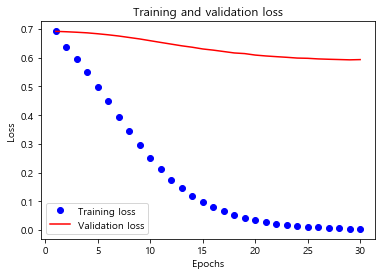

In [110]:
%matplotlib inline
import matplotlib.pyplot as plt

history_dict = history.history
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [111]:
score = model.evaluate(X_test, y_test)
print(score)

ValueError: Failed to find data adapter that can handle input: <class 'numpy.ndarray'>, (<class 'list'> containing values of types {"<class 'int'>"})

In [112]:
from keras.layers import SimpleRNN, LSTM

model = Sequential()
model.add(Embedding(max_words, 32))
#model.add(SimpleRNN(32))
model.add(LSTM(32))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 33        
Total params: 328,353
Trainable params: 328,353
Non-trainable params: 0
_________________________________________________________________


In [113]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

history = model.fit(X_train, y_train, 
                    epochs=30,
                    batch_size=256,
                    validation_split=0.2)

Epoch 1/30
5/5 [==============================] - 3s 631ms/step - loss: 0.6930 - acc: 0.4984 - val_loss: 0.6918 - val_acc: 0.5688
Epoch 2/30
5/5 [==============================] - 3s 526ms/step - loss: 0.6857 - acc: 0.6922 - val_loss: 0.6879 - val_acc: 0.5625
Epoch 3/30
5/5 [==============================] - 3s 568ms/step - loss: 0.7179 - acc: 0.6648 - val_loss: 0.6720 - val_acc: 0.6469
Epoch 4/30
5/5 [==============================] - 3s 596ms/step - loss: 0.6072 - acc: 0.8109 - val_loss: 0.6452 - val_acc: 0.5906
Epoch 5/30
5/5 [==============================] - 3s 583ms/step - loss: 0.5770 - acc: 0.8313 - val_loss: 0.5959 - val_acc: 0.6969
Epoch 6/30
5/5 [==============================] - 3s 620ms/step - loss: 0.5700 - acc: 0.8156 - val_loss: 0.6101 - val_acc: 0.7375
Epoch 7/30
5/5 [==============================] - 3s 573ms/step - loss: 0.4398 - acc: 0.9148 - val_loss: 0.6467 - val_acc: 0.5906
Epoch 8/30
5/5 [==============================] - 3s 541ms/step - loss: 0.4480 - acc: 0.85

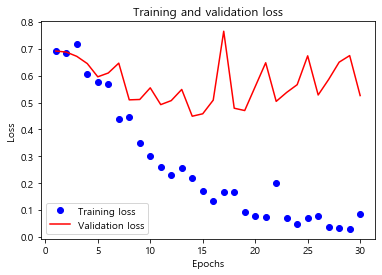

In [114]:
history_dict = history.history
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

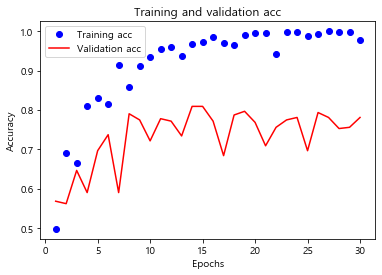

In [115]:
history_dict = history.history
acc = history_dict['acc']
val_acc = history_dict['val_acc']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [116]:
score = model.evaluate(X_test, y_test)
print(score)

ValueError: Failed to find data adapter that can handle input: <class 'numpy.ndarray'>, (<class 'list'> containing values of types {"<class 'int'>"})

## pre-trained embedding을 사용
GloVe: https://nlp.stanford.edu/projects/glove <br>
다운 받아서 datasets 폴더 안에 압축을 풀고 그 중에서 glove.6B.100d.txt를 사용<br>

파일 안의 모양: 단어 + 단어의 100차원 vector 집합으로 이루어져 있음<br>

예) the -0.038194 -0.24487 0.72812 -0.39961 0.083172 0.043953 -0.39141 0.3344 -0.57545 0.087459 0.28787 -0.06731 0.30906 -0.26384 -0.13231 -0.20757 0.33395 -0.33848 -0.31743 -0.48336 0.1464 -0.37304 0.34577 0.052041 0.44946 -0.46971 0.02628 -0.54155 -0.15518 -0.14107 -0.039722 0.28277 0.14393 0.23464 -0.31021 0.086173 0.20397 0.52624 0.17164 -0.082378 -0.71787 -0.41531 0.20335 -0.12763 0.41367 0.55187 0.57908 -0.33477 -0.36559 -0.54857 -0.062892 0.26584 0.30205 0.99775 -0.80481 -3.0243 0.01254 -0.36942 2.2167 0.72201 -0.24978 0.92136 0.034514 0.46745 1.1079 -0.19358 -0.074575 0.23353 -0.052062 -0.22044 0.057162 -0.15806 -0.30798 -0.41625 0.37972 0.15006 -0.53212 -0.2055 -1.2526 0.071624 0.70565 0.49744 -0.42063 0.26148 -1.538 -0.30223 -0.073438 -0.28312 0.37104 -0.25217 0.016215 -0.017099 -0.38984 0.87424 -0.72569 -0.51058 -0.52028 -0.1459 0.8278 0.27062

한 라인은 하나의 단어와 그 단어의 vector로 이루어져 있으므로, 각 라인에 대해 첫 token을 word로, 나머지 100 token을 vector로 변환하면 됨 

In [120]:
glove_dir = './glove.6B/'
import os
import numpy as np

embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'), encoding='utf8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Num of word vectors:', len(embeddings_index))

Num of word vectors: 400000


In [121]:
# 처음 데이터를 생성할 때 사용한 tokenizer에서 word_index를 추출
# 이 word_index에 맞게 glove로부터 해당하는 word vector를 가져옴
word_index = tokenizer.word_index
len(word_index)

43296

In [122]:
#embedding matrix를 생성: word_index에서 max_words 만큼의 단어에 대해 glove의 embeddings_index를 추출하여 matrix 생성
#추출한 matrix는 embedding 층의 weight로 고정해서 사용함

embedding_dim = 100 # glove의 vector dimension
embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    if i < max_words:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

In [123]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Embedding
from keras.layers import SimpleRNN, LSTM

model = Sequential()
model.add(Embedding(max_words, embedding_dim))
#model.add(SimpleRNN(32))
model.add(LSTM(32))
model.add(Dense(1, activation='sigmoid'))

In [124]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False #값을 고정
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, None, 100)         1000000   
_________________________________________________________________
lstm_2 (LSTM)                (None, 32)                17024     
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 33        
Total params: 1,017,057
Trainable params: 17,057
Non-trainable params: 1,000,000
_________________________________________________________________


In [125]:
from keras import optimizers
#rmsprop = optimizers.RMSprop(lr=0.0001, rho=0.9, epsilon=None, decay=0.0) #default lr은 0.001
#rmsprop = optimizers.RMSprop(lr=0.005) #default lr은 0.001
adam = optimizers.Adam(lr=0.005) #default lr은 0.001

# pre-train이 되어 있으므로 적은 수의 test set으로도 학습이 가능
model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['acc'])

history = model.fit(X_train, y_train, 
                    epochs=30,
                    batch_size=256,
                    validation_split=0.2) 
#model.save_weights('pre_trained_glove_model.h5')

Epoch 1/30
5/5 [==============================] - 5s 1s/step - loss: 0.6929 - acc: 0.5148 - val_loss: 0.6774 - val_acc: 0.5875
Epoch 2/30
5/5 [==============================] - 4s 779ms/step - loss: 0.6612 - acc: 0.6078 - val_loss: 0.6597 - val_acc: 0.6156
Epoch 3/30
5/5 [==============================] - 4s 779ms/step - loss: 0.6308 - acc: 0.6414 - val_loss: 0.6335 - val_acc: 0.6562
Epoch 4/30
5/5 [==============================] - 4s 794ms/step - loss: 0.6194 - acc: 0.6531 - val_loss: 0.6728 - val_acc: 0.6000
Epoch 5/30
5/5 [==============================] - 4s 817ms/step - loss: 0.6052 - acc: 0.6641 - val_loss: 0.6262 - val_acc: 0.6562
Epoch 6/30
5/5 [==============================] - 4s 839ms/step - loss: 0.5871 - acc: 0.6992 - val_loss: 0.6196 - val_acc: 0.6531
Epoch 7/30
5/5 [==============================] - 4s 866ms/step - loss: 0.5632 - acc: 0.7125 - val_loss: 0.5868 - val_acc: 0.6687
Epoch 8/30
5/5 [==============================] - 5s 918ms/step - loss: 0.5298 - acc: 0.7383 

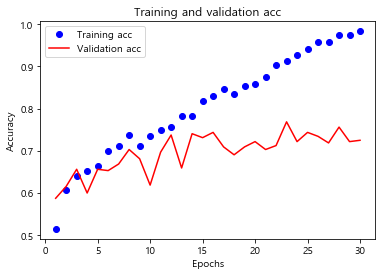

In [126]:
history_dict = history.history
acc = history_dict['acc']
val_acc = history_dict['val_acc']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [127]:
score = model.evaluate(X_test, y_test)
print(score)

ValueError: Failed to find data adapter that can handle input: <class 'numpy.ndarray'>, (<class 'list'> containing values of types {"<class 'int'>"})

### glove를 사용하지 않으면서 좀 더 정교한 모형을 사용하여 학습
optimizer를 정교하게 조정하고, regularizer를 추가

In [128]:
from keras.layers import SimpleRNN, LSTM
from keras import regularizers

model = Sequential()
model.add(Embedding(max_words, 32))
#model.add(SimpleRNN(32))
model.add(LSTM(32))
#model.add(Dense(32, kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(1, activation='sigmoid', kernel_regularizer=regularizers.l2(0.1))) #0.01을 먼저 시도했음

model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, None, 32)          320000    
_________________________________________________________________
lstm_3 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 33        
Total params: 328,353
Trainable params: 328,353
Non-trainable params: 0
_________________________________________________________________


In [129]:
from keras import optimizers
#adam = optimizers.Adam(lr=0.005) #default lr은 0.001
rmsprop = optimizers.RMSprop(lr=0.005) #default lr은 0.001

model.compile(optimizer=rmsprop, loss='binary_crossentropy', metrics=['acc']) 
#lr 조절 없고 l2=0.01일 때 test 0.775 나옴

history = model.fit(X_train, y_train, 
                    epochs=30,
                    batch_size=256,
                    validation_split=0.2) 

Epoch 1/30
5/5 [==============================] - 4s 893ms/step - loss: 0.8272 - acc: 0.5047 - val_loss: 0.7901 - val_acc: 0.6125
Epoch 2/30
5/5 [==============================] - 5s 1s/step - loss: 0.7655 - acc: 0.6547 - val_loss: 0.7510 - val_acc: 0.5938
Epoch 3/30
5/5 [==============================] - 4s 877ms/step - loss: 0.5924 - acc: 0.8367 - val_loss: 0.7426 - val_acc: 0.6438
Epoch 4/30
5/5 [==============================] - 4s 826ms/step - loss: 0.4920 - acc: 0.8523 - val_loss: 0.7355 - val_acc: 0.6656
Epoch 5/30
5/5 [==============================] - 4s 803ms/step - loss: 0.3822 - acc: 0.9406 - val_loss: 0.7006 - val_acc: 0.7031
Epoch 6/30
5/5 [==============================] - 4s 776ms/step - loss: 0.2869 - acc: 0.9633 - val_loss: 0.7276 - val_acc: 0.6812
Epoch 7/30
5/5 [==============================] - 4s 845ms/step - loss: 0.3862 - acc: 0.9094 - val_loss: 0.7357 - val_acc: 0.6469
Epoch 8/30
5/5 [==============================] - 4s 761ms/step - loss: 0.2605 - acc: 0.9812 

In [130]:
score = model.evaluate(X_test, y_test)
print(score)

ValueError: Failed to find data adapter that can handle input: <class 'numpy.ndarray'>, (<class 'list'> containing values of types {"<class 'int'>"})

# 문제점

- 모델 점수 출력에서 에러가 난다.